## Load saved raw data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw_data_snapshot.csv")
print("Shape:", df.shape)
df.head()


Shape: (28156, 14)


,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes
3,3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,Navy FCU,In progress,Yes,NaN
4,4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068.0,2015-03-19,2015-03-19,Transworld Systems Inc.,In progress,Yes,NaN


## Missing values analysis

C:\Users\Dev\AppData\Local\Temp\ipykernel_7668\1095066130.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


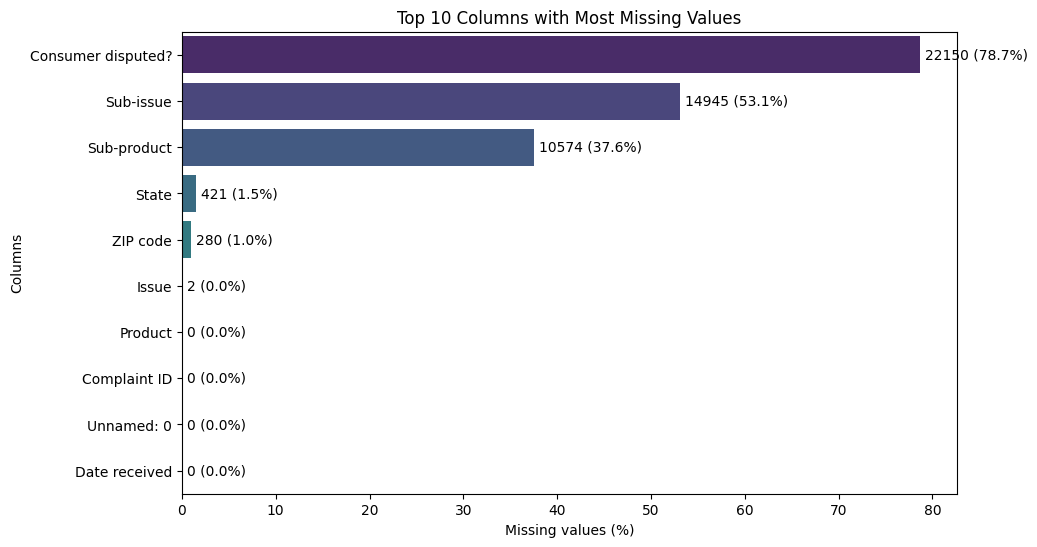

,count,percent
Consumer disputed?,22150,78.668845
Sub-issue,14945,53.079273
Sub-product,10574,37.555050
State,421,1.495241
ZIP code,280,0.994459
Issue,2,0.007103
Product,0,0.000000
Complaint ID,0,0.000000
Unnamed: 0,0,0.000000
Date received,0,0.000000


In [4]:
# Missing values: counts and percentages
missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df)) * 100

# Create DataFrame for top 10 missing
missing_df = (
    pd.DataFrame({
        "count": missing_counts,
        "percent": missing_percent
    })
    .sort_values("count", ascending=False)
    .head(10)
)

# Visualization
plt.figure(figsize=(10,6))
sns.barplot(
    x="percent", 
    y=missing_df.index, 
    data=missing_df, 
    palette="viridis"
)

# Add count labels on bars
for i, (count, perc) in enumerate(zip(missing_df["count"], missing_df["percent"])):
    plt.text(perc + 0.5, i, f"{count} ({perc:.1f}%)", va="center")

plt.xlabel("Missing values (%)")
plt.ylabel("Columns")
plt.title("Top 10 Columns with Most Missing Values")
plt.show()

# Show table as well
missing_df


## Missing values by product

In [5]:
# Unique value counts (excluding missing) for high-missing columns
for col in ["Consumer disputed?", "Sub-issue", "Sub-product"]:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts(dropna=True))

# How many rows have all three of these columns missing?
high_miss = ["Consumer disputed?", "Sub-issue", "Sub-product"]
all_missing = df[high_miss].isna().all(axis=1).sum()
print(f"\nRows with ALL of {high_miss} missing: {all_missing}")

# Pattern of missingness by Product
for col in high_miss:
    miss_by_product = df.groupby("Product")[col].apply(lambda x: x.isna().mean()).sort_values(ascending=False)
    print(f"\nMissing % of '{col}' by Product (top 5):")
    print(miss_by_product.head(5).to_string())



Value counts for 'Consumer disputed?':
Consumer disputed?
Yes    4708
No     1298
Name: count, dtype: int64

Value counts for 'Sub-issue':
Sub-issue
Debt is not mine                            2125
Account status                              1604
Information is not mine                     1307
Debt was paid                                890
Not given enough info to verify debt         815
Frequent or repeated calls                   754
Account terms                                484
Attempted to collect wrong amount            482
Right to dispute notice not received         387
Problem getting my free annual report        386
Public record                                356
Talked to a third party about my debt        289
Personal information                         258
Threatened to take legal action              246
Problem with statement of dispute            243
No notice of investigation status/result     241
Debt resulted from identity theft            205
Problem getting r

## Exploration of categorical variables

In [6]:
# Exploration of key categorical variables relevant for modeling
key_cols = ["Product", "Issue", "Company response", "Timely response?"]

for col in key_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts(dropna=False).head(10))



Value counts for 'Product':
Product
Debt collection            7494
Mortgage                   6612
Credit reporting           5717
Credit card                2830
Bank account or service    2609
Consumer loan              1314
Student loan                785
Payday loan                 348
Money transfers             232
Prepaid card                175
Name: count, dtype: int64

Value counts for 'Issue':
Issue
Incorrect information on credit report      4170
Cont'd attempts collect debt not owed       3351
Loan modification,collection,foreclosure    3049
Loan servicing, payments, escrow account    2627
Disclosure verification of debt             1300
Communication tactics                       1251
Account opening, closing, or management     1142
Deposits and withdrawals                     690
Credit reporting company's investigation     638
False statements or representation           624
Name: count, dtype: int64

Value counts for 'Company response':
Company response
Closed with e

## Target variable + date feature engineering

In [7]:
# Target variable distribution
print("Target variable 'Timely response?' balance:")
print(df["Timely response?"].value_counts(normalize=True))

# Extract date parts as features
df['Date received'] = pd.to_datetime(df['Date received'], errors='coerce')
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'], errors='coerce')
df['Response_delay_days'] = (df['Date sent to company'] - df['Date received']).dt.days  

print(df[['Date received', 'Date sent to company', 'Response_delay_days']].head())

# Correlation check
print("\nCorrelation matrix for numeric features:")
print(df.select_dtypes(include=['int64', 'float64']).corr())


Target variable 'Timely response?' balance:
Timely response?
Yes    0.974712
No     0.025288
Name: proportion, dtype: float64
  Date received Date sent to company  Response_delay_days
0    2015-03-19           2015-03-19                    0
1    2015-03-19           2015-03-19                    0
2    2015-03-19           2015-03-19                    0
3    2015-03-19           2015-03-19                    0
4    2015-03-19           2015-03-19                    0

Correlation matrix for numeric features:
                     Unnamed: 0  Complaint ID  ZIP code  Response_delay_days
Unnamed: 0             1.000000     -0.997081  0.000435             0.093532
Complaint ID          -0.997081      1.000000  0.001352            -0.098712
ZIP code               0.000435      0.001352  1.000000             0.016365
Response_delay_days    0.093532     -0.098712  0.016365             1.000000


## Time series visualization

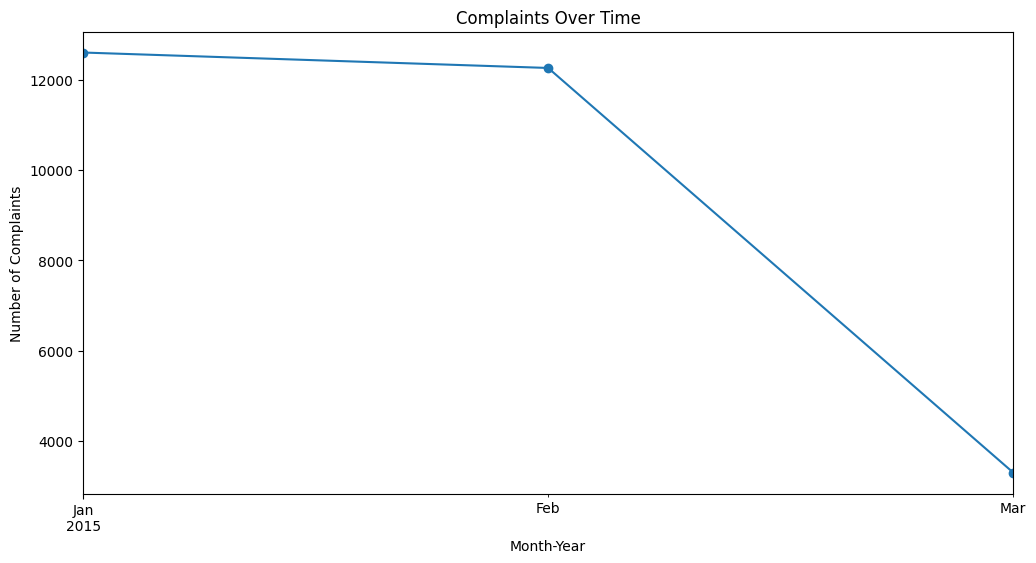

In [8]:
df['Received_month_year'] = df['Date received'].dt.to_period('M')
monthly_complaints = df.groupby('Received_month_year').size()
plt.figure(figsize=(12,6))
monthly_complaints.plot(kind='line', marker='o')
plt.title('Complaints Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Complaints')
plt.show()


## Timely response by product

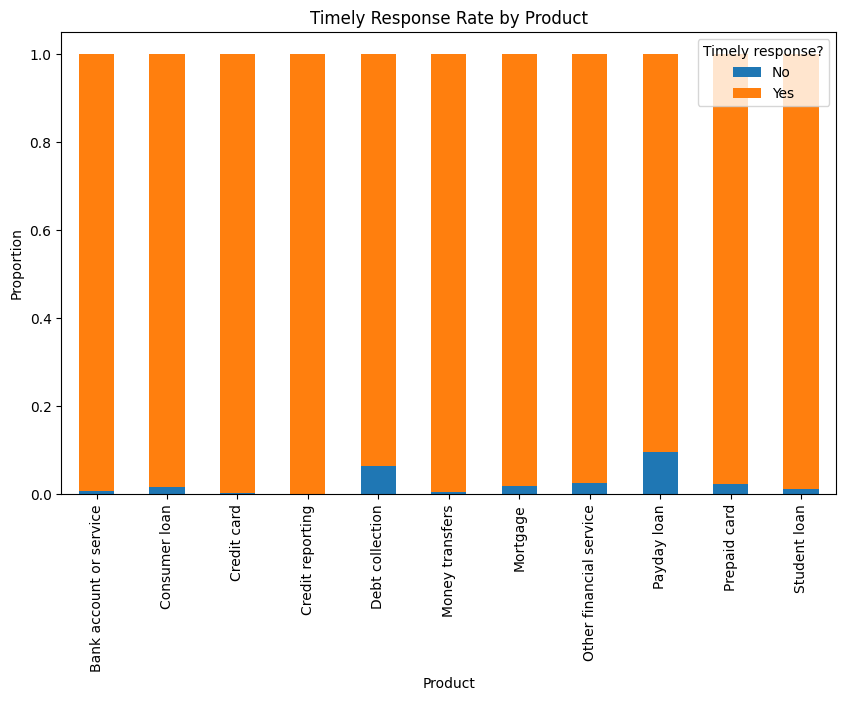

Timely response?               No       Yes
Product                                    
Bank account or service  0.007282  0.992718
Consumer loan            0.017504  0.982496
Credit card              0.002827  0.997173
Credit reporting         0.001224  0.998776
Debt collection          0.064718  0.935282


In [9]:
timely_by_product = df.groupby('Product')['Timely response?'].value_counts(normalize=True).unstack().fillna(0)
timely_by_product.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Timely Response Rate by Product')
plt.ylabel('Proportion')
plt.show()

print(timely_by_product.head())


## Cramer’s V correlation test

In [10]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

print("Cramer's V between Product and Timely response?:", cramers_v(df['Product'], df['Timely response?']))


Cramer's V between Product and Timely response?: 0.16788300068007397


## Categorical encoding + missing values

In [11]:
# Convert suitable columns to categorical dtype
cat_cols = ["Product", "Issue", "Company response", "Consumer disputed?", "Timely response?"]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# For missing values, fill with "Missing"
for col in cat_cols:
    if df[col].isna().any():
        df[col] = df[col].cat.add_categories("Missing").fillna("Missing")

print(df[cat_cols].info())
print(df[cat_cols].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Product             28156 non-null  category
 1   Issue               28156 non-null  category
 2   Company response    28156 non-null  category
 3   Consumer disputed?  28156 non-null  category
 4   Timely response?    28156 non-null  category
dtypes: category(5)
memory usage: 141.2 KB
None
           Product                                     Issue  \
0  Debt collection                     Communication tactics   
1  Debt collection     Cont'd attempts collect debt not owed   
2         Mortgage  Application, originator, mortgage broker   
3      Credit card                                     Other   
4  Debt collection     Cont'd attempts collect debt not owed   

          Company response Consumer disputed? Timely response?  
0              In progress            Missin

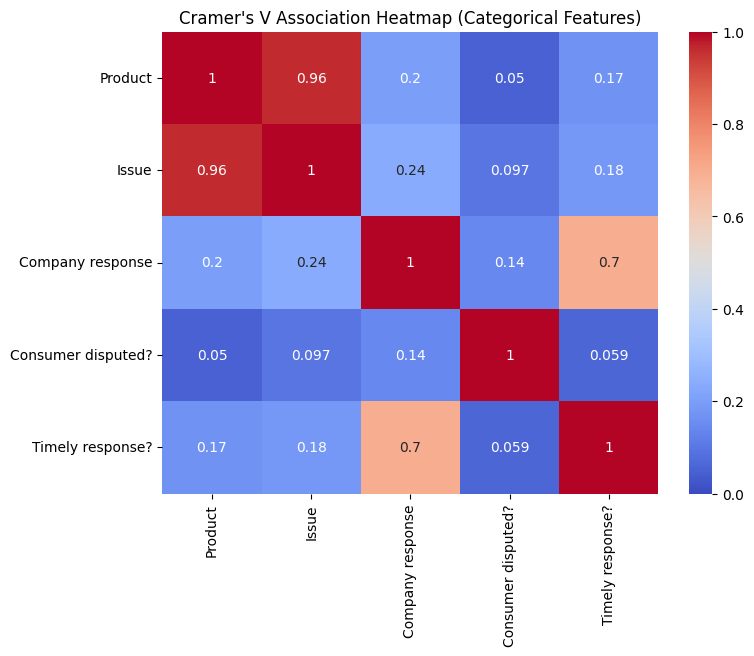

In [12]:
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def cramers_v(x, y):
    """Compute Cramer's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Select categorical columns
cat_cols = ["Product", "Issue", "Company response", "Consumer disputed?", "Timely response?"]

# Compute pairwise Cramer's V
cramers_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cramers_matrix.astype(float), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramer's V Association Heatmap (Categorical Features)")
plt.show()


## Save cleaned dataset

In [13]:
df.to_csv("../data/clean_data.csv", index=False)
print("Clean data saved at ./data/clean_data.csv")


Clean data saved at ./data/clean_data.csv
